## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 5 or 6 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
#only if you have jupyterthemes
#from jupyterthemes import jtplot
#jtplot.style()

### Download Cifar10 dataset

In [ ]:
torch.cuda.is_available()

True

In [ ]:
DATA_PATH = './cifar10'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [ ]:
train_loader.batch_size

64

In [ ]:
for i, (x, y) in enumerate(train_loader):
    print(x, y)

### Using  GPUs

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Mostrar imágenes

La imagen muestreada representa un: frog


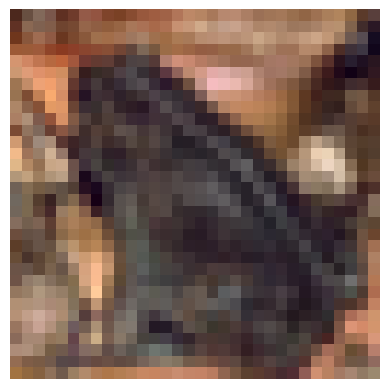

In [ ]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


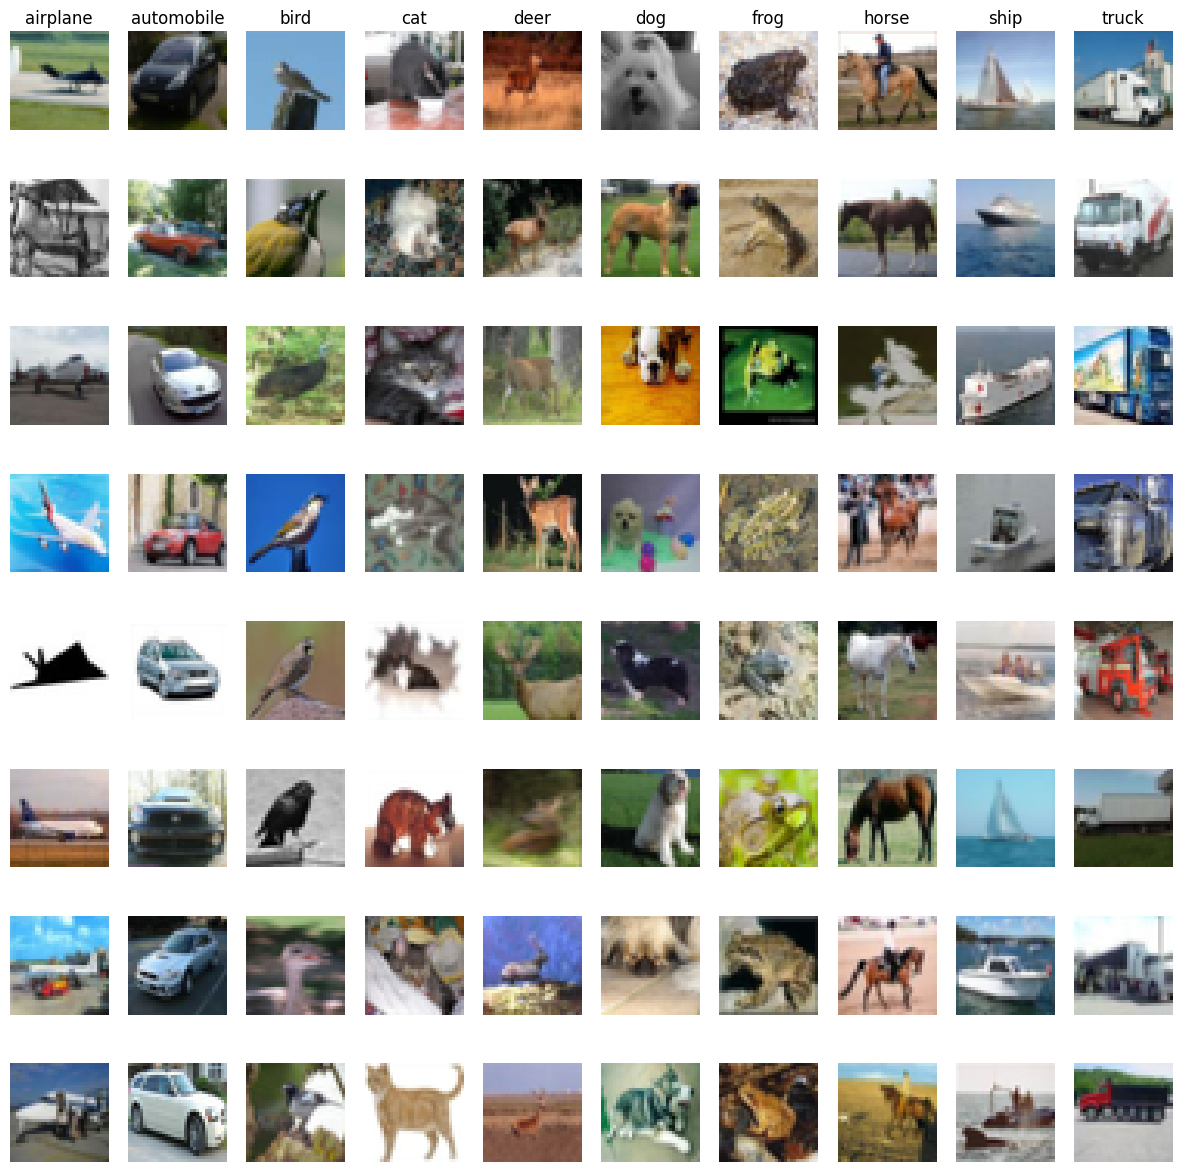

In [ ]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')

            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid()

### Calcular accuracy


In [ ]:
def accuracy(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for x, y in loader:
            x, y = x.to(device), y.to(device)  # Move both to the device at once
            scores = model(x)  # Forward pass
            _, predictions = scores.max(1)  # Get the index of the max log-probability
            correct += (predictions == y).sum().item()  # Accumulate correct predictions
            total += y.size(0)  # Accumulate total samples (batch size)

    return correct / total  # Return overall accuracy


### Loop de entrenamiento

In [ ]:
def train(model, optimiser, epochs=100):
    # Transfer model to the device
    model = model.to(device=device)

    # Lists to store loss and accuracy for each epoch
    loss_values = []
    val_acc_values = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        # Loop over batches
        for x, y in train_loader:
            # Transfer data to device
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            scores = model(x)
            loss = F.cross_entropy(scores, y)  # Compute loss

            # Backpropagation and optimization
            optimiser.zero_grad()  # Clear previous gradients
            loss.backward()  # Compute new gradients
            optimiser.step()  # Update weights

            # Accumulate loss
            running_loss += loss.item()

        # Calculate average loss over all batches
        avg_loss = running_loss / len(train_loader)
        loss_values.append(avg_loss)

        # Calculate training and validation accuracy
        train_acc = accuracy(model, train_loader)  # Compute training accuracy
        val_acc = accuracy(model, val_loader)  # Compute validation accuracy
        val_acc_values.append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}')

    # Compute test accuracy after training
    test_acc = accuracy(model, test_loader)
    print(f'Test Accuracy: {test_acc:.4f}')

    # Plotting the loss and validation accuracy
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss_values, label='Training Loss', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_acc_values, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()



### Linear model

In [ ]:
# To do: Use PyTorch to create a linear model to have an initial baseline model
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3*32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)


model1 = LinearModel()
lr = 1e-4
epochs = 10
optimiser = torch.optim.Adam(model1.parameters(), lr=lr)

Epoch 1/10, Loss: 1.6721, Train Accuracy: 0.4804, Val Accuracy: 0.4720
Epoch 2/10, Loss: 1.4560, Train Accuracy: 0.5276, Val Accuracy: 0.5054
Epoch 3/10, Loss: 1.3505, Train Accuracy: 0.5628, Val Accuracy: 0.5210
Epoch 4/10, Loss: 1.2720, Train Accuracy: 0.5910, Val Accuracy: 0.5382
Epoch 5/10, Loss: 1.2060, Train Accuracy: 0.6128, Val Accuracy: 0.5378
Epoch 6/10, Loss: 1.1467, Train Accuracy: 0.6386, Val Accuracy: 0.5464
Epoch 7/10, Loss: 1.0918, Train Accuracy: 0.6597, Val Accuracy: 0.5494
Epoch 8/10, Loss: 1.0395, Train Accuracy: 0.6734, Val Accuracy: 0.5500
Epoch 9/10, Loss: 0.9890, Train Accuracy: 0.6920, Val Accuracy: 0.5466
Epoch 10/10, Loss: 0.9417, Train Accuracy: 0.7132, Val Accuracy: 0.5480
Test Accuracy: 0.5458


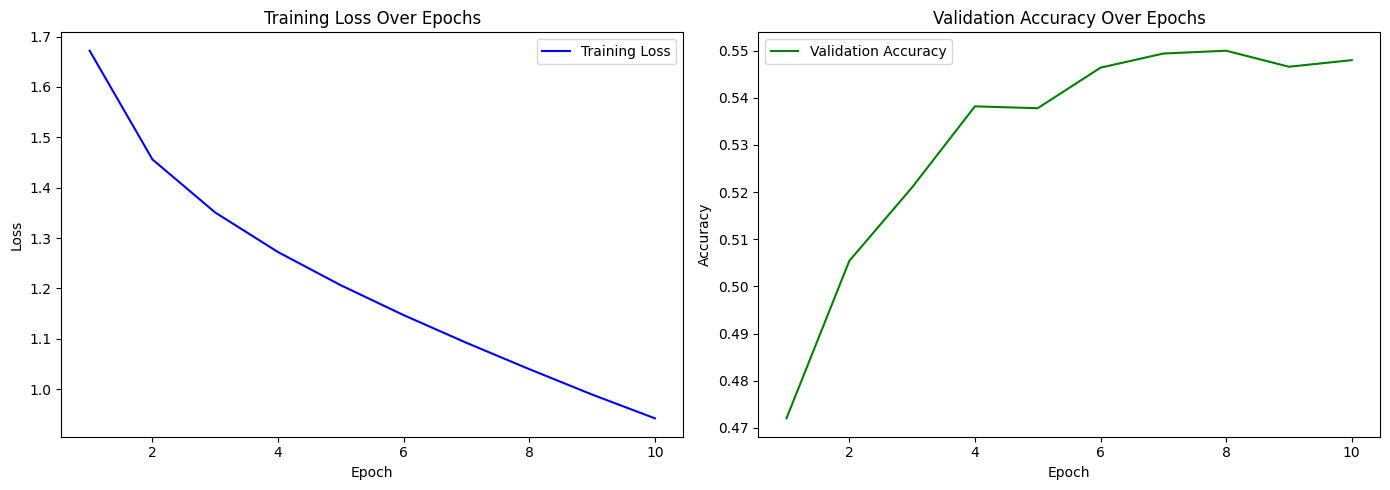

In [ ]:
# Setup random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

train(model1, optimiser, epochs)

### Sequential CNN

#### Model proposal architecture 1:

In this experiment, we apply max pooling after each of the 3 convolutional layers, which reduces the image size at each step, aiming to balance computational efficiency and data preservation. Although examples suggest using max pooling every 2 convolutional layers, we apply it more frequently to observe its effect here. We limit the network to 3 layers to prevent excessive reduction in the image size before reaching the fully connected layers.

In [ ]:
# To do: Use PyTorch to implement a CNN model, accuracy should be better than
#the linear model

input_channels = 3
hidden_1 = 32
hidden_2 = 64
hidden_3 = 128

class ModelCNNProposal1(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers (Sequential block)
        self.conv_layers = nn.Sequential(
            # First conv block: 32x32x3 -> 32x32x32
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_1, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 32x32 -> 16x16

            # Second conv block: 16x16x32 -> 16x16x64
            nn.Conv2d(in_channels=hidden_1, out_channels=hidden_2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 16x16 -> 8x8

            # Third conv block: 8x8x64 -> 8x8x128
            nn.Conv2d(in_channels=hidden_2, out_channels=hidden_3, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 8x8 -> 4x4
        )

        # Fully connected layers (Sequential block)
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  # Flatten output from conv layers
            nn.Linear(128 * 4 * 4, 512),  # Fully connected with 512 units
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout for regularization
            nn.Linear(512, 256),  # 256 hidden units
            nn.ReLU(),
            nn.Linear(256, 10)  # Output layer: 10 classes for CIFAR-10
        )

    def forward(self, x):
        # Pass through convolutional layers
        x = self.conv_layers(x)

        # Pass through fully connected layers
        x = self.fc_layers(x)

        return x


In [ ]:
# Grid search over learning rates

def grid_search(learning_rates, model_class):
    epochs = 10

    # List to store results
    results = []
    history = {'lr': [], 'epoch': [], 'loss': [], 'val_accuracy': []}  # To store values for plotting

    # Grid search over all combinations of learning rates
    for index, lr in enumerate(learning_rates):
        print(f"Training [{index+1}/{len(learning_rates)}]: lr={lr:.0e}")

        # Setup random seed for reproducibility
        torch.manual_seed(42)
        np.random.seed(42)

        # Initialize the model
        model = model_class().to(device)

        # Use Adam optimizer with the current learning rate
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Loss function
        criterion = nn.CrossEntropyLoss()

        # Train model
        best_val_accuracy = 0

        for epoch in range(epochs):
            model.train()
            loss_values = []
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                loss_values.append(loss.item())
            running_loss = np.mean(loss_values)

            # Evaluate on validation set
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_accuracy = correct / total

            print(f"Epoch [{epoch+1}], Loss: {running_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

            # Keep track of the best validation accuracy for this combination
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy

            # Store history for plotting
            history['lr'].append(lr)
            history['epoch'].append(epoch + 1)
            history['loss'].append(running_loss)
            history['val_accuracy'].append(val_accuracy)

        # Store the result for this combination of hyperparameters
        results.append({
            'lr': lr,
            'val_accuracy': best_val_accuracy
        })

    # Find the best combination of hyperparameters
    best_result = max(results, key=lambda x: x['val_accuracy'])
    return best_result, history


In [ ]:
# Define the grid of hyperparameters
learning_rates = [1e-4, 1e-3, 1e-2]

best_result, history = grid_search(learning_rates, ModelCNNProposal1)

print(f"Best Hyperparameters for the model ModelCNNProposal1: {best_result['lr']:.0e}")

Training [1/3]: lr=1e-04
Epoch [1], Loss: 1.4490, Val Accuracy: 0.6062
Epoch [2], Loss: 1.0661, Val Accuracy: 0.6636
Epoch [3], Loss: 0.9245, Val Accuracy: 0.6990
Epoch [4], Loss: 0.8389, Val Accuracy: 0.7208
Epoch [5], Loss: 0.7623, Val Accuracy: 0.7234
Epoch [6], Loss: 0.7061, Val Accuracy: 0.7388
Epoch [7], Loss: 0.6520, Val Accuracy: 0.7516
Epoch [8], Loss: 0.6085, Val Accuracy: 0.7576
Epoch [9], Loss: 0.5661, Val Accuracy: 0.7340
Epoch [10], Loss: 0.5302, Val Accuracy: 0.7628
Training [2/3]: lr=1e-03
Epoch [1], Loss: 1.3357, Val Accuracy: 0.6484
Epoch [2], Loss: 0.9888, Val Accuracy: 0.6778
Epoch [3], Loss: 0.8482, Val Accuracy: 0.7270
Epoch [4], Loss: 0.7635, Val Accuracy: 0.7520
Epoch [5], Loss: 0.6810, Val Accuracy: 0.7542
Epoch [6], Loss: 0.6209, Val Accuracy: 0.7606
Epoch [7], Loss: 0.5697, Val Accuracy: 0.7874
Epoch [8], Loss: 0.5170, Val Accuracy: 0.7788
Epoch [9], Loss: 0.4731, Val Accuracy: 0.7854
Epoch [10], Loss: 0.4332, Val Accuracy: 0.7886
Training [3/3]: lr=1e-02
Epo

Showing the history of the training for the best learning rate for the model ModelCNNProposal1


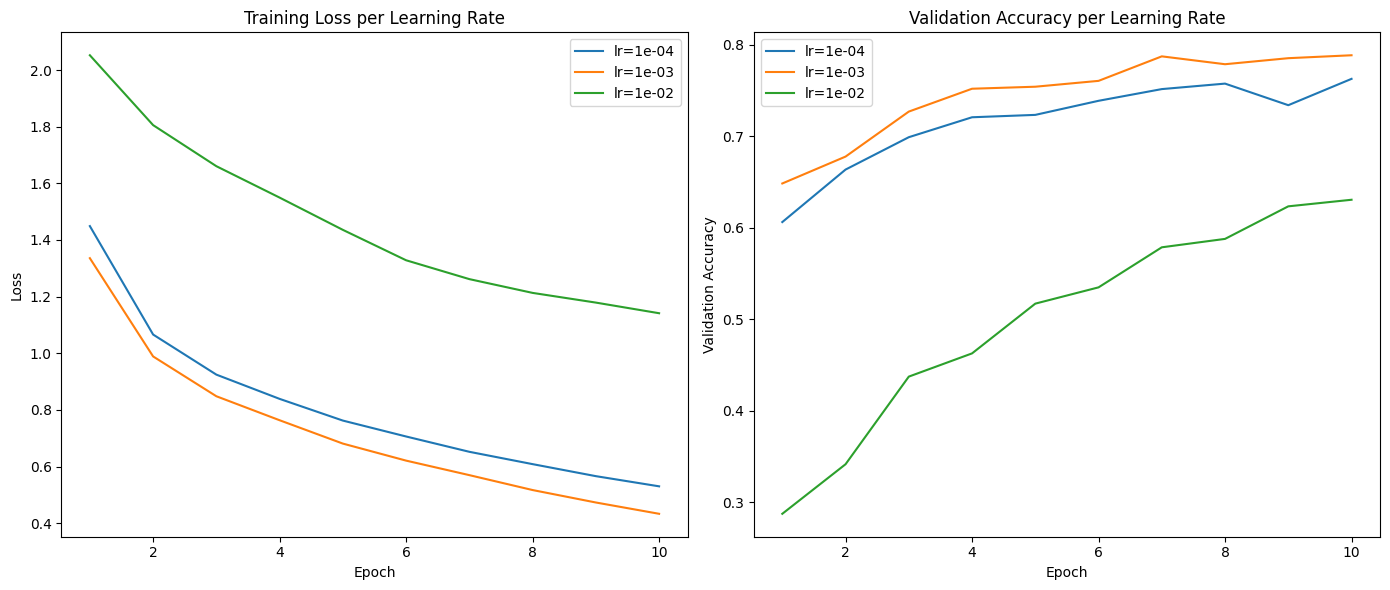

In [ ]:
print(f"Showing the history of the training for the best learning rate for the model ModelCNNProposal1")

# Plotting the results using matplotlib

# Convert history to numpy arrays for easier plotting
history['lr'] = np.array(history['lr'])
history['epoch'] = np.array(history['epoch'])
history['loss'] = np.array(history['loss'])
history['val_accuracy'] = np.array(history['val_accuracy'])

# Create a plot for loss and validation accuracy
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for lr in learning_rates:
    lr_mask = history['lr'] == lr
    plt.plot(history['epoch'][lr_mask], history['loss'][lr_mask], label=f'lr={lr:.0e}')
plt.title('Training Loss per Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
for lr in learning_rates:
    lr_mask = history['lr'] == lr
    plt.plot(history['epoch'][lr_mask], history['val_accuracy'][lr_mask], label=f'lr={lr:.0e}')
plt.title('Validation Accuracy per Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10, Loss: 1.3354, Train Accuracy: 0.6497, Val Accuracy: 0.6478
Epoch 2/10, Loss: 0.9856, Train Accuracy: 0.7344, Val Accuracy: 0.7182
Epoch 3/10, Loss: 0.8513, Train Accuracy: 0.7599, Val Accuracy: 0.7314
Epoch 4/10, Loss: 0.7586, Train Accuracy: 0.7826, Val Accuracy: 0.7464
Epoch 5/10, Loss: 0.6870, Train Accuracy: 0.8128, Val Accuracy: 0.7690
Epoch 6/10, Loss: 0.6330, Train Accuracy: 0.8172, Val Accuracy: 0.7620
Epoch 7/10, Loss: 0.5730, Train Accuracy: 0.8400, Val Accuracy: 0.7708
Epoch 8/10, Loss: 0.5197, Train Accuracy: 0.8785, Val Accuracy: 0.7906
Epoch 9/10, Loss: 0.4719, Train Accuracy: 0.8895, Val Accuracy: 0.7922
Epoch 10/10, Loss: 0.4335, Train Accuracy: 0.8993, Val Accuracy: 0.7912
Test Accuracy: 0.7936


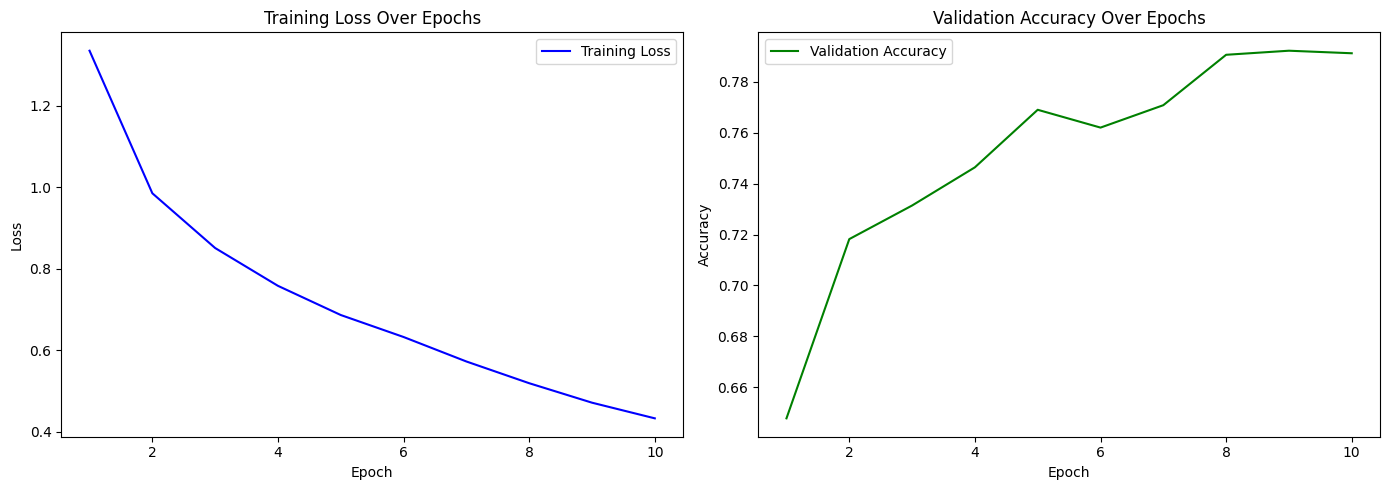

In [ ]:
# Setup random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

modelCNN1 = ModelCNNProposal1()
optimiser = torch.optim.Adam(modelCNN1.parameters(), lr=best_result['lr'])
epochs = 10

train(modelCNN1, optimiser, epochs)

#### Model proposal architecture 2:

This model, ModelCNNProposal2, consists of two main convolutional blocks, each containing two convolutional layers, followed by batch normalization and ReLU activation to improve learning efficiency and prevent vanishing gradients. The first block starts with 16 channels and increases to 32 channels, with a max pooling layer to reduce the feature map from 32x32 to 16x16. The second block follows the same pattern, starting with 64 channels and increasing to 128, further reducing the feature map size to 8x8. After flattening the output, a fully connected layer reduces the data to 10 output classes, corresponding to CIFAR-10. This architecture is designed to capture richer features at each step, progressively increasing the number of channels while using batch normalization to ensure better performance compared to a simple linear model.

We decided to use this architecture to experiment using a more suggested structure in the literature, and compare with our first approach.

In [ ]:
# Try 2 with a different model

# Model 2

class ModelCNNProposal2(nn.Module):
    def __init__(self):
        super().__init__()

        channel1 = 16
        channel2 = 32
        channel3 = 64
        channel4 = 128

        # First block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> MaxPool
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=channel1, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel1),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel1, out_channels=channel2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Second block: Conv -> BatchNorm -> ReLU -> Conv -> BatchNorm -> ReLU -> MaxPool
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=channel2, out_channels=channel3, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel3),
            nn.ReLU(),
            nn.Conv2d(in_channels=channel3, out_channels=channel4, kernel_size=3, padding=1),
            nn.BatchNorm2d(channel4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Fully connected layer
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8*channel4, out_features=10)
        )

    def forward(self, x):
        x = self.block1(x)  # First block forward pass
        x = self.block2(x)  # Second block forward pass
        x = self.fc(x)  # Fully connected layer forward pass
        return x

In [ ]:
# Define the grid of hyperparameters
learning_rates = [1e-4, 1e-3, 1e-2]

best_result, history = grid_search(learning_rates, ModelCNNProposal2)

print(f"Best Hyperparameters for the model ModelCNNProposal2: {best_result['lr']:.0e}")

Training [1/3]: lr=1e-04
Epoch [1], Loss: 1.3443, Val Accuracy: 0.6210
Epoch [2], Loss: 0.9646, Val Accuracy: 0.6570
Epoch [3], Loss: 0.8257, Val Accuracy: 0.7002
Epoch [4], Loss: 0.7358, Val Accuracy: 0.7086
Epoch [5], Loss: 0.6686, Val Accuracy: 0.7156
Epoch [6], Loss: 0.6142, Val Accuracy: 0.7214
Epoch [7], Loss: 0.5537, Val Accuracy: 0.7246
Epoch [8], Loss: 0.5091, Val Accuracy: 0.7238
Epoch [9], Loss: 0.4665, Val Accuracy: 0.7378
Epoch [10], Loss: 0.4247, Val Accuracy: 0.7312
Training [2/3]: lr=1e-03
Epoch [1], Loss: 1.3507, Val Accuracy: 0.6666
Epoch [2], Loss: 0.8637, Val Accuracy: 0.6966
Epoch [3], Loss: 0.7198, Val Accuracy: 0.7432
Epoch [4], Loss: 0.6220, Val Accuracy: 0.7410
Epoch [5], Loss: 0.5399, Val Accuracy: 0.7810
Epoch [6], Loss: 0.4711, Val Accuracy: 0.7720
Epoch [7], Loss: 0.3957, Val Accuracy: 0.7868
Epoch [8], Loss: 0.3327, Val Accuracy: 0.7730
Epoch [9], Loss: 0.2698, Val Accuracy: 0.7792
Epoch [10], Loss: 0.2194, Val Accuracy: 0.8016
Training [3/3]: lr=1e-02
Epo

Showing the history of the training for the best learning rate for the model ModelCNNProposal2


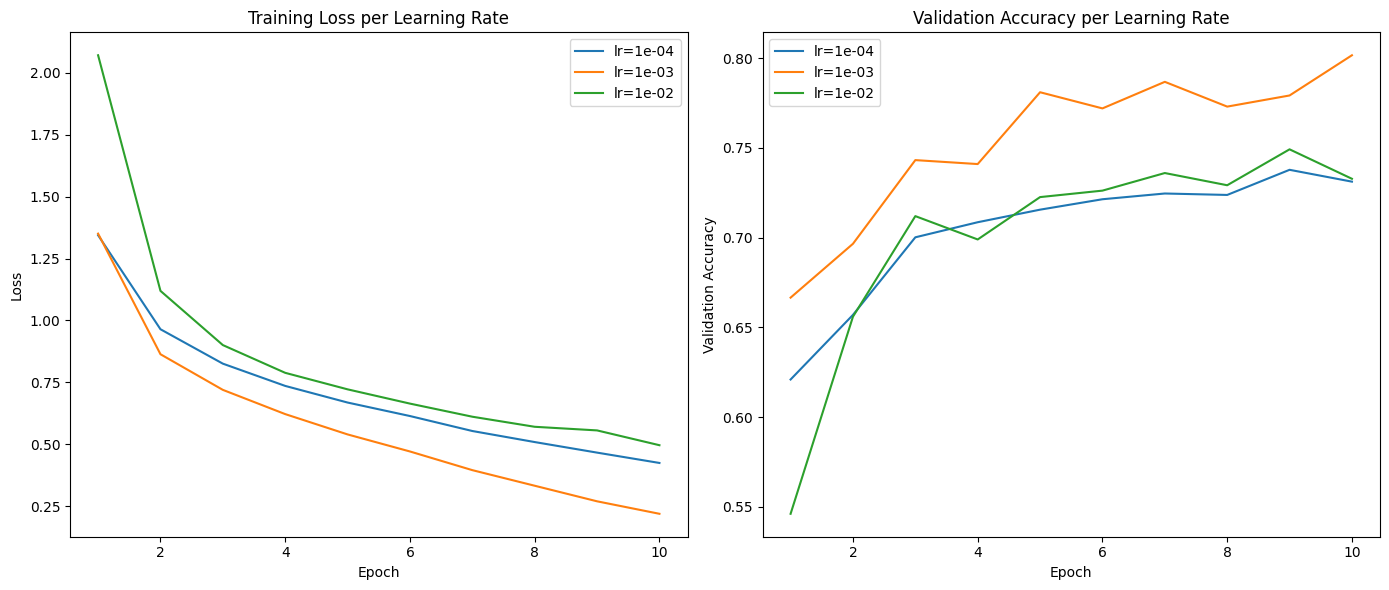

In [ ]:
print(f"Showing the history of the training for the best learning rate for the model ModelCNNProposal2")

# Plotting the results using matplotlib

# Convert history to numpy arrays for easier plotting
history['lr'] = np.array(history['lr'])
history['epoch'] = np.array(history['epoch'])
history['loss'] = np.array(history['loss'])
history['val_accuracy'] = np.array(history['val_accuracy'])

# Create a plot for loss and validation accuracy
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
for lr in learning_rates:
    lr_mask = history['lr'] == lr
    plt.plot(history['epoch'][lr_mask], history['loss'][lr_mask], label=f'lr={lr:.0e}')
plt.title('Training Loss per Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Validation Accuracy Plot
plt.subplot(1, 2, 2)
for lr in learning_rates:
    lr_mask = history['lr'] == lr
    plt.plot(history['epoch'][lr_mask], history['val_accuracy'][lr_mask], label=f'lr={lr:.0e}')
plt.title('Validation Accuracy per Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/10, Loss: 1.3502, Train Accuracy: 0.6913, Val Accuracy: 0.6684
Epoch 2/10, Loss: 0.8680, Train Accuracy: 0.7427, Val Accuracy: 0.7158
Epoch 3/10, Loss: 0.7215, Train Accuracy: 0.7912, Val Accuracy: 0.7478
Epoch 4/10, Loss: 0.6207, Train Accuracy: 0.8109, Val Accuracy: 0.7558
Epoch 5/10, Loss: 0.5396, Train Accuracy: 0.8476, Val Accuracy: 0.7742
Epoch 6/10, Loss: 0.4653, Train Accuracy: 0.8745, Val Accuracy: 0.7796
Epoch 7/10, Loss: 0.3955, Train Accuracy: 0.8802, Val Accuracy: 0.7708
Epoch 8/10, Loss: 0.3303, Train Accuracy: 0.9129, Val Accuracy: 0.7786
Epoch 9/10, Loss: 0.2710, Train Accuracy: 0.9327, Val Accuracy: 0.7896
Epoch 10/10, Loss: 0.2169, Train Accuracy: 0.9412, Val Accuracy: 0.7854
Test Accuracy: 0.7758


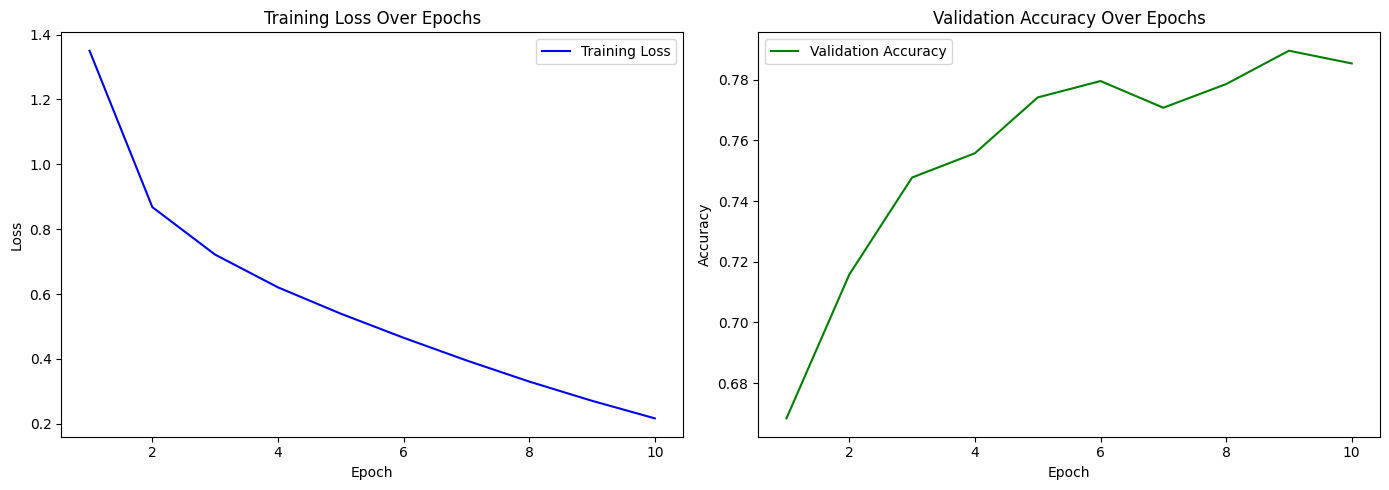

In [ ]:
# Setup random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

modelCNN2 = ModelCNNProposal2()
optimiser = torch.optim.Adam(modelCNN2.parameters(), lr=best_result['lr'])
epochs = 10

train(modelCNN2, optimiser, epochs)

### Conclusion

The preferred data subset for this exercise was the CIFAR-10 with 60,000 32x32 color images spread across 10 classes of images that belong to different categories like airplanes, cars, and animals, besides others. 50,000 images are utilized for training while 5,000 are allocated for validation and the other 5,000 are categorized for testing, which are then normalized to the mean and standard deviation of the dataset.

This project utilized two different CNN architectures. The first one was composed of three convolutional blocks, incrementally increasing output channels (32, 64, and 128), max pooling layers, a flattening layer, and two fully connected layers (512 and 256 units). The activation function in use was ReLU, for dropout as regularization layer, and the output layer for the classification of the 10 different CIFAR-10 classes. The second architecture was more focused, and it comprised two layers of two convolutional layers and batch normalization, a max-pooling block each. The first block had 16 and 32 output channels, while the second one had 32 and 128. The fully connected layer was utilized to transform the output and to map it to the 10 classes.

Both models scored almost equally well: the first CNN registered a test accuracy of 0.8004, and the second one had 0.7928. Even though the first, more sophisticated architecture had slightly better results than the second, it also used a great deal of computational resources. To be specific, both the CNNs succeeded in outperforming the linear model, the working of which was done as follows: the input images were flattened in the first step and were then passed through two fully connected layers (512 and 128 units) before the classification.

In optimizing the learning rate for both CNNs, grid search was the tool that was applied, and it was found that the best decision was to set the value to 1e-3 which resulted in every time the model was trained for 10 epochs and the batch size of 64 was utilized. The number of epochs was chosen as 10 since it is possible to observe that after passing 10 epochs, the performance curve in the validation accuracy flattens out.